In [6]:
# !wget -q https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task

In [7]:
import urllib

IMAGE_FILENAMES = ['thumbs_down.jpg', 'victory.jpg', 'thumbs_up.jpg', 'pointing_up.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/{name}'
  urllib.request.urlretrieve(url, name)

In [8]:
#@markdown We implemented some functions to visualize the gesture recognition results. <br/> Run the following cell to activate the functions.
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [9]:
import cv2
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2.imshow("test",img)
  cv2.waitKey(0)


# Preview the images.
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

thumbs_down.jpg
victory.jpg
thumbs_up.jpg
pointing_up.jpg


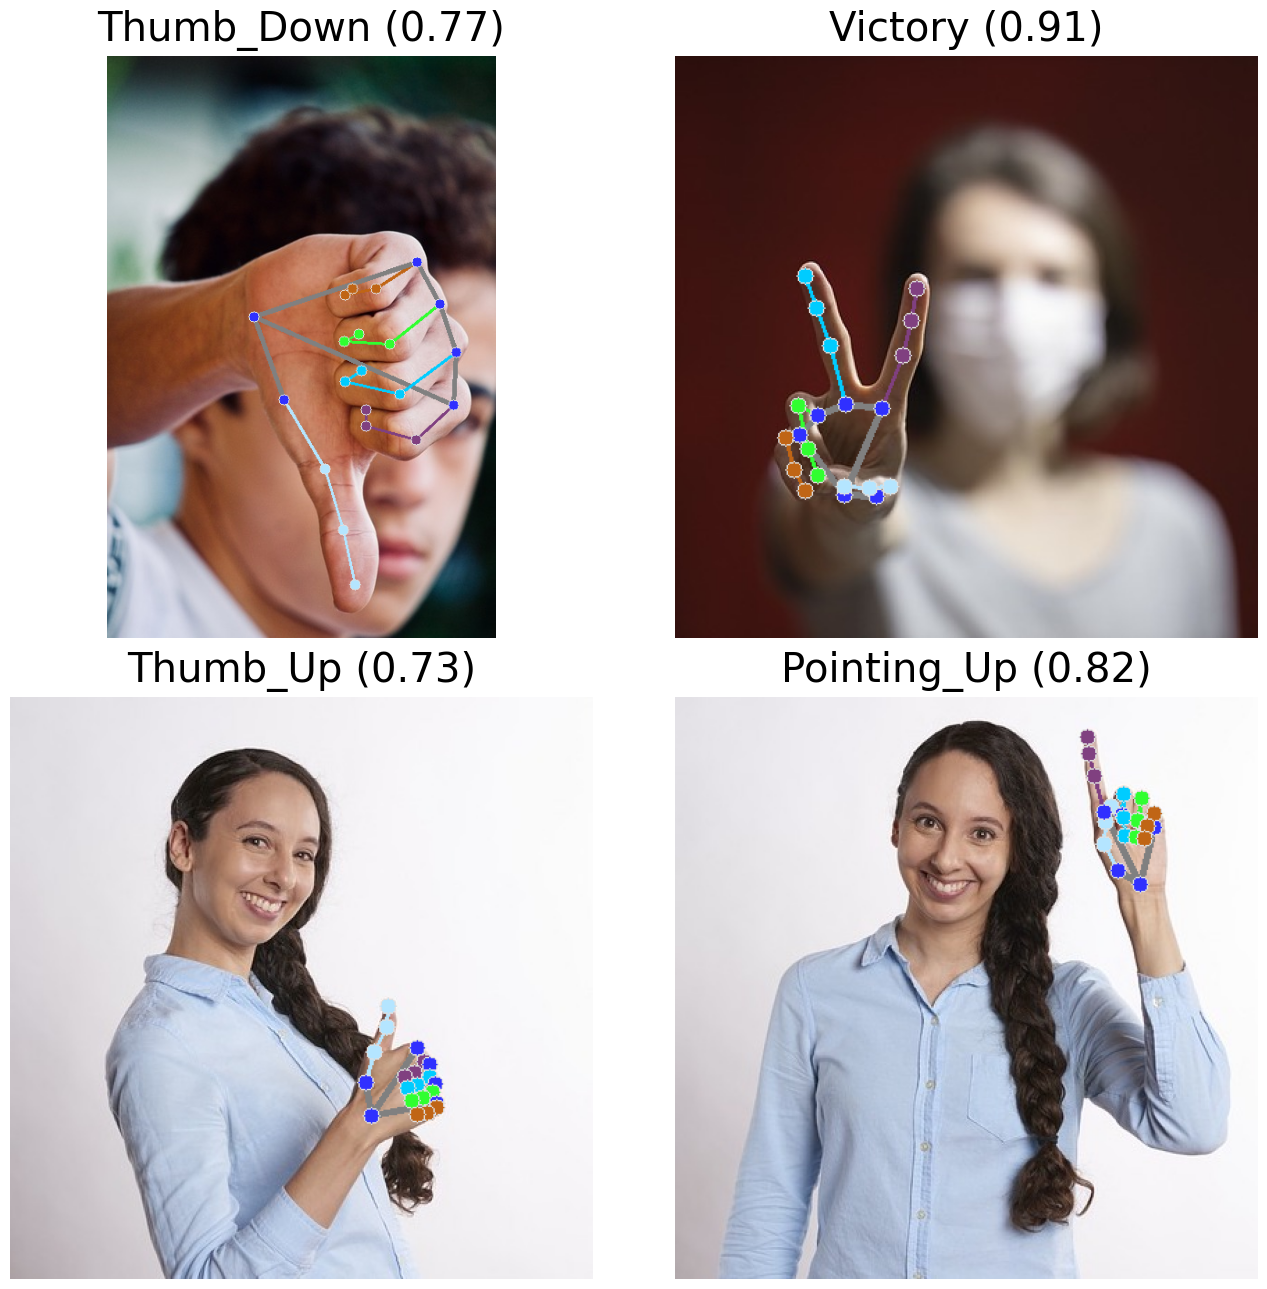

In [10]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

images = []
results = []
for image_file_name in IMAGE_FILENAMES:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_file_name)

  # STEP 4: Recognize gestures in the input image.
  recognition_result = recognizer.recognize(image)

  # STEP 5: Process the result. In this case, visualize it.
  images.append(image)
  top_gesture = recognition_result.gestures[0][0]
  hand_landmarks = recognition_result.hand_landmarks
  results.append((top_gesture, hand_landmarks))

display_batch_of_images_with_gestures_and_hand_landmarks(images, results)

In [ ]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# For webcam input:
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
with mp_hands.Hands(
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      # print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    recognition_result = recognizer.recognize(image)
    results = hands.process(image)
    top_gesture = recognition_result.gestures[0][0]
    hand_landmarks = recognition_result.hand_landmarks
    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    display_batch_of_images_with_gestures_and_hand_landmarks()
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == ord('q'):  # press q to quit
        print("Exiting...")          
        cap.release()
        cv2.destroyAllWindows()
        break